## Abstract

We wondered how protein language models trained on extant sequences would interpret plausible ancestral sequences. To explore this, we used ESM2 to evaluate maximum likelihood ancestral sequence reconstructions for two example gene families. We found that ESM2 often finds these ancestral sequences more plausible than extant descendants, and can distinguish between crude consensus ancestral sequences and more sophisticated maximum likelihood reconstructions. However, these patterns are context and model dependent, suggesting that further investigation is needed to determine which evolutionary relationships are truly captured by large protein language models like ESM2.

----

:::{.callout-note title="AI usage disclosure" collapse="true"}
This is a placeholder for the AI usage disclosure. Once all authors sign the AI code form on AirTable, SlackBot will message you an AI disclosure that you should place here.
:::


## Introduction

Protein language models have emerged as powerful tools for computational biology applications, including fitness prediction, generative protein design, structure prediction, and functional annotation. These models are trained on vast databases of naturally occurring protein sequences with the expectation that they will capture complex relationships underlying these sequences: from fundamental biophysical constraints to evolutionary pressures that have shaped modern proteins (@lin_evolutionary-scale_2023, @hayes_simulating_2025, @bhatnagar_scaling_2025). However, the extent to which these models have learned genuine evolutionary principles versus surface-level sequence patterns, and how this varies across model architectures, remains an open question (@lupo_protein_2022, @ektefaie_sequence_2025, @tule_protein_2025, @york_phylogenies_2025).

Ancestral sequence reconstruction (ASR) is a potentially useful framework for addressing this question. ASR employs statistical methods to infer the most probable protein sequences of extinct ancestral organisms based on phylogenetic relationships among extant sequences. While these reconstructions may not represent the exact sequences that existed in the past, they reflect evolutionarily plausible intermediates under established models of molecular evolution, and in many cases have been shown to fold and function (@hochberg_reconstructing_2017). This approach offers two key features for probing evolutionary knowledge encoded in protein language models. First, training datasets consist exclusively of extant sequences. Reconstructed ancestral sequences provide opportunities to evaluate the ability of these models to generalize to new sequences. Second, unlike other types of novel sequences, reconstructed ancestral sequences are unique in their evolutionary plausibility. ASR has been successfully applied to reconstruct and experimentally characterize diverse protein families, demonstrating that many reconstructed sequences represent functionally viable proteins (@bridgham2006, @voordeckers_reconstruction_2012, @wilson_using_2015). Thus, ancestral proteins provide an opportunity to assess model confidence in evolutionarily plausible sequences never observed during training and infer the generalizability of evolutionary knowledge contained within pLMs.  

Here, we focus on the ESM2 protein language model (@lin_evolutionary-scale_2023), one of the most widely used and well-characterized models to date. ESM2 is trained on millions of extant protein sequences from UniRef and has been applied to a wide range of prediction tasks. It includes multiple model sizes, ranging from 8 million to 15 billion parameters, allowing us to examine how model behavior varies with scale.

## ADA1 ancestral reconstruction

We began this analysis with the human protein ADA1, an adenosine deaminase that plays a crucial role in purine metabolism. ADA1 offered several advantages as a test case: it is relatively small (363 amino acids), making computationally intensive pseudo-perplexity calculations more tractable, and is relatively well conserved across taxa, allowing for high-confidence sequence alignments and ancestral reconstructions.

We performed ASR on ADA1 by identifying homologs using Protein Cartography, aligning proteins with MAFFT, building a phylogenetic tree with IQTree, reconstructing maximum likelihood ancestral sequences using PAML, and inferring insertions and deletions using PastML (as in @orlandi_topiary_2023). This reconstruction was performed outside of this notebook and can be found in“ASR/ASR_notebook.ipynb” (output files are available in “ASR/ADA1_ASR”).

::: {.callout-note}
The ancestral reconstructions were performed outside of this notebook, in the notebook `ASR/ASR_notebook.ipynb` with output files in `ASR/ADA1_ASR`.  This step was conducted separately to keep the main analysis here focused and uncluttered, as ancestral reconstruction involves a multi-stage pipeline with its own set of dependencies and intermediate steps. The reconstruction can be reproduced by running the notebook in an environment with the required dependencies specified in `envs/asr_env.yaml`. The notebook will output the reconstructed ancestral sequences in FASTA format, which can then be used as input for the pseudo-perplexity calculations.
:::

To determine the confidence of the ESM2 model in these ancestral sequences, we used pseudo-perplexity as our primary metric (@lin_evolutionary-scale_2023 , @salazar_masked_2020). Pseudo-perplexity quantifies how well a protein language model can predict each amino acid in a sequence given the surrounding context, essentially measuring the model’s "surprise" at encountering each individual residue. A pseudo-perplexity value near 20 indicates that the model is highly uncertain and assigns roughly equal probability to all 20 amino acids, while a value closer to 1 indicates strong confidence in its prediction. In practice, pseudo-perplexity is computed by summing the negative log-likelihoods of each residue prediction across the entire sequence, yielding a sequence-level score that reflects how grammatically consistent a model believes the sequence to be based on its training on natural proteins. Lower pseudo-perplexity values, therefore, suggest higher plausibility under the model’s learned distribution. By analyzing pseudo-perplexity scores across ancestral sequences with different evolutionary age, we aimed to assess whether protein language models can infer the plausibility of ancestrally reconstructed sequences and how their confidence varies across evolutionary time.


## ADA1 phylogeny

We first wanted to assess how ESM2 pseudo-perplexity varies between ancestral and native sequences and the effect of ancestral age. To start, we looked at the human ADA1 protein P00813.

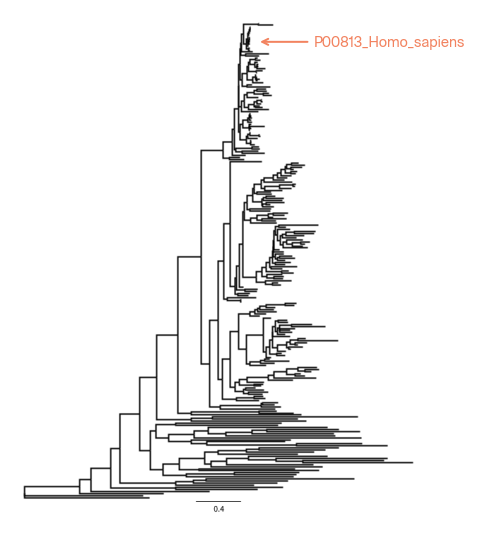

In [1]:
# | code-fold: true
# | label: fig-1
# | fig-cap: Phylogenetic tree of ADA1 homologs with location of human ADA1 indicated by arrow.


import arcadia_pycolor as apc

from data_processing import plot_image_with_arrow_and_circles, plot_image_with_arrows

apc.mpl.setup()

img_path = "images/ADA1_tree.png"
plot_image_with_arrows(
    img_path,
    x_starts=[0.73],
    x_ends=[0.60],
    arrow_ys=[0.045],
    labels=["P00813_Homo_sapiens"],
    text_offsets=[0.01],
)

We determined every ancestral node leading to this extant leaf and its maximum likelihood ancestral sequence, as shown in the example below.

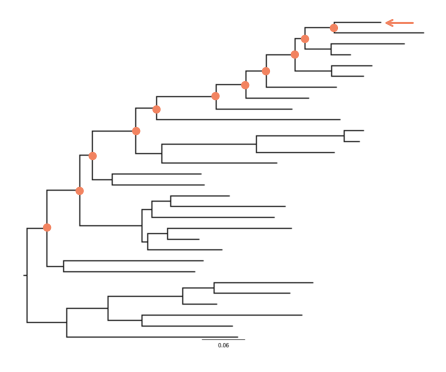

In [2]:
# | code-fold: true
# | label: fig-2
# | fig-cap: Example of all ancestral nodes (orange circles) on the lineage of an example leaf of interest (orange arrow). The basal node of the tree was not included, as our ASR pipeline does not reconstruct this node.

node_img_path = "images/tree_nodes_example.png"
plot_image_with_arrow_and_circles(
    img_path=node_img_path,
    x_start=0.97,
    x_end=0.89,
    arrow_y=0.01,
    circle_positions=[
        (0.771, 0.025),
        (0.70, 0.058),
        (0.675, 0.105),
        (0.604, 0.155),
        (0.553, 0.197),
        (0.48, 0.23),
        (0.335, 0.27),
        (0.285, 0.335),
        (0.178, 0.41),
        (0.146, 0.515),
        (0.066, 0.625),
    ],
    circle_radius=6,
)

## Loading the data

We calculated pseudo-perplexity scores using the 650M ESM2 model for relevant ancestral sequences and extant sequences in our dataset to begin inferring model confidence of reconstructed sequences.

::: {.callout-note}
This analysis was performed on an Amazon EC2 g4dn.2xlarge instance using the custom script `esm2_pppl_calculator.py`. Because this required GPU compute for efficient execution, it was conducted separately from the main notebook. To reproduce the analysis, follow the instructions provided in `README.md` and run the script in an environment configured with the dependencies listed in `envs/esm2_env.yaml`.
:::

In addition to pseudo-perplexity values, we extracted the mean posterior probabilities for each ancestral reconstruction from the PAML output. Posterior probability in this context represents the statistical confidence of the maximum likelihood reconstruction.  Specifically, it quantifies the probability that each amino acid at each position in the ancestral sequence is correctly inferred given the appropriate phylogenetic model and observed extant sequences. Higher values, close to 1.0, indicate high confidence in the protein reconstruction. 

To quantify evolutionary divergence, we calculated the total branch length from the root to each ancestral node and extant leaf in our phylogenetic tree, in order to examine how ESM2 confidence varies across evolutionary age.

In [3]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
from Bio import Phylo

# Import ADA1 sequences scored for ESM2 pppl
all_scores = pd.read_csv("ESM2_scoring/ADA1_all_esm2_scores_650M.csv")
all_scores = all_scores[["sequence_id", "sequence", "pseudo_perplexity"]]

# Retrieve ML posterior probabilities from ASR run
ml_probs_json = "ASR/ADA1_ASR/posterior_probabilities_no_gaps.json"
ml_probs_json = Path(ml_probs_json)
with open(ml_probs_json) as f:
    probs_dict = json.load(f)

# Add posterior probabilities to dataframe
all_scores["ML prob"] = all_scores["sequence_id"].apply(
    lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan
)

# Import phylogenetic tree to infer ancestors of leaf of interest
tree_file = "ASR/ADA1_ASR/ancestor_tree.txt"
tree = Phylo.read(tree_file, "newick")

# Calculate the branch length to the root for every ancestor and native sequence
from data_processing import calc_branch_length_to_root_leaf, calc_branch_length_to_root_node

all_scores["bl_to_root"] = all_scores["sequence_id"].apply(
    lambda x: calc_branch_length_to_root_node(tree, x[4:])
    if x.startswith("node")
    else calc_branch_length_to_root_leaf(tree, x)
)

## Visualizing ESM2 pseudo-perplexity vs. evolutionary distance

Plotting ESM2 pseudo-perplexity scores against evolutionary distance from the tree root allows us to examine the effect of both ancestral age (distance to tree root) and reconstruction confidence (posterior probability) on the pseudo-perplexity score.

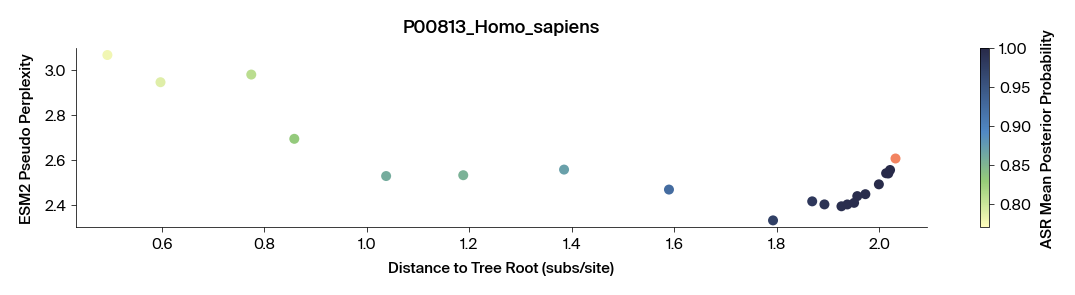

In [4]:
# | label: fig-3
# | fig-cap: ESM2 pseudo-perplexity scores for ADA1 sequences, colored by ML posterior probability bin. The x-axis shows the branch length to the root node of the tree, with the extant sequence on the far right (orange). The y-axis shows ESM2 pseudo-perplexity score.

from data_processing import get_node_labels_leaf_to_root, plot_evo_path

plot_evo_path(all_scores, tree, "P00813_Homo_sapiens")

ESM2 assigns lower pseudo-perplexity scores to recent ancestral sequences compared to the extant human sequence, suggesting that the model considers these reconstructed ancestors more plausible than the native sequence. This is intriguing given that these ancestral sequences were never present in the training data, and may indicate that ESM2 has inferred specific evolutionary patterns sufficiently to recognize some high-confidence ancestral reconstructions as sound.

However, as evolutionary distance increases, pseudo-perplexity scores rise and eventually surpass the native score. This suggests the model finds these basal ancestors less plausible than the native and more recent ancestral sequences. 

We wondered how general this phenomenon was, so we examined three additional extant leaves in our ADA1 phylogenetic tree and ancestral nodes on their respective lineages.


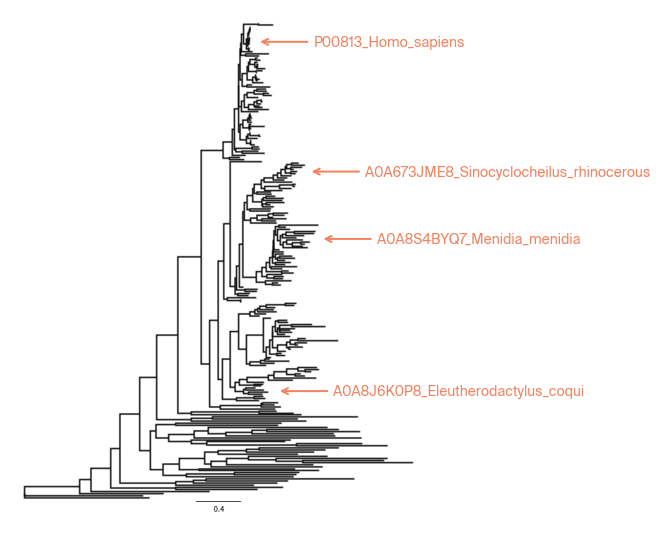

In [5]:
# | code-fold: true
# | label: fig-4
# | fig-cap: Phylogenetic tree of ADA1 with additional extant leaf positions indicated by arrows.

plot_image_with_arrows(
    img_path,
    x_starts=[0.73, 0.89, 0.86, 0.78],
    x_ends=[0.60, 0.76, 0.73, 0.65],
    arrow_ys=[0.045, 0.44, 0.305, 0.745],
    labels=[
        "P00813_Homo_sapiens",
        "A0A8S4BYQ7_Menidia_menidia",
        "A0A673JME8_Sinocyclocheilus_rhinocerous",
        "A0A8J6K0P8_Eleutherodactylus_coqui",
    ],
    text_offsets=[0.01, 0.01, 0.01, 0.01],
)

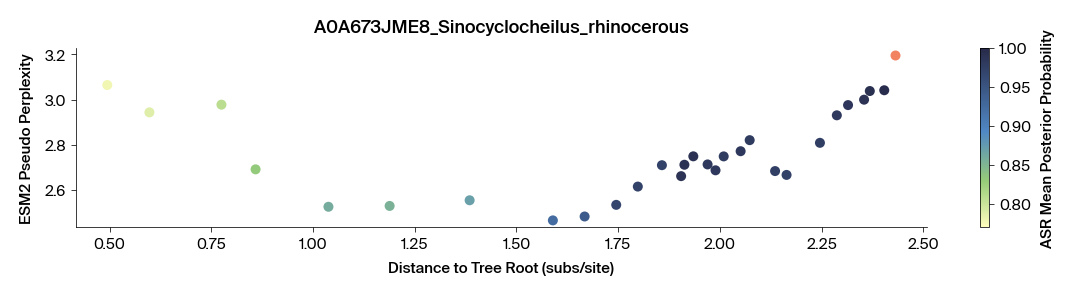

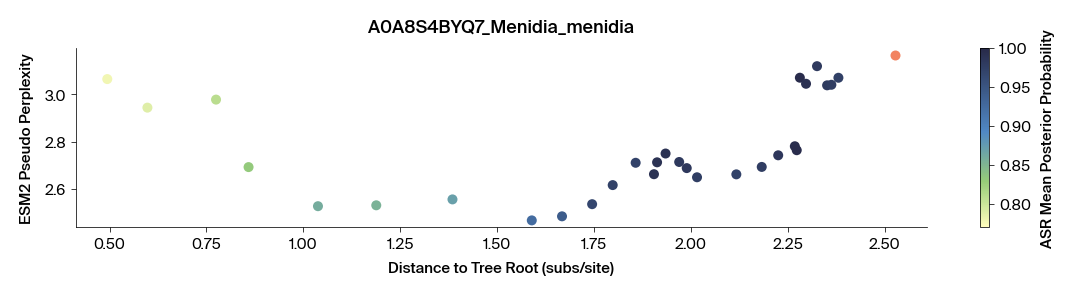

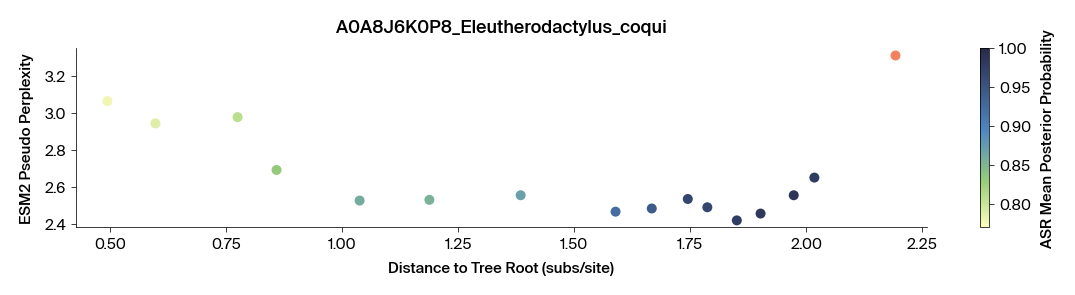

In [6]:
# | label: fig-5
# | column: body
# | fig-cap: ESM2 pseudo-perplexity vs distance to tree root for three additional species lineages.
# | fig-subcap:
# |   - " "
# |   - " "
# |   - " "

plot_evo_path(all_scores, tree, "A0A673JME8_Sinocyclocheilus_rhinocerous")
plot_evo_path(all_scores, tree, "A0A8S4BYQ7_Menidia_menidia")
plot_evo_path(all_scores, tree, "A0A8J6K0P8_Eleutherodactylus_coqui")

Here we see a similar pattern: recent ancestors show lower pseudo-perplexity scores than their native descendants, but these scores increase for the oldest ancestors. Unlike human ADA1, however, none of these other ancestors showed higher pseudo-perplexity scores than their native sequences, suggesting this isn't universal. This may reflect the lower baseline score of human ADA1 compared to the others, perhaps due to over-representation of human and closely related sequences in the training set compared to these other species. However, we consistently observe that ESM2 considers many ancestral sequences more plausible than native sequences across different species.

## Assessing the role of consensus effects

We wondered whether ESM’s general preference for ancestral sequences reflects primarily a consensus effect in these models. Maximum likelihood ancestral reconstructions, while statistically based, often favor amino acids that are common among descendant sequences, potentially creating sequences that align with the frequency distributions in the ESM2 training data. Therefore, ESM2 might prefer these sequences simply because they contain high-frequency amino acids.

To test this hypothesis, we generated "consensus ancestors" as controls. For each ancestral node, we identified all extant sequences descending from that node. We constructed a consensus sequence by choosing the most frequent amino acid found at each position in the alignment. This relatively simple approach differs fundamentally from maximum likelihood reconstruction, which incorporates evolutionary models, branch lengths, and substitution matrices to infer the most probable ancestral state given the entire phylogenetic context.

In [7]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from data_processing import generate_node_consensus, get_node_labels_leaf_to_root

leaves_of_interest = [
    "P00813_Homo_sapiens",
    "A0A8S4BYQ7_Menidia_menidia",
    "A0A673JME8_Sinocyclocheilus_rhinocerous",
    "A0A8J6K0P8_Eleutherodactylus_coqui",
]
ancestors_of_interest = []

for entry in leaves_of_interest:
    ancestors_of_interest.extend(get_node_labels_leaf_to_root(tree, entry))

ancestors_of_interest = list(set(ancestors_of_interest))

alignment_file = "ASR/ADA1_ASR/ADA1_curated_022525_under420_recoded_mafft.fa"
name_conv_dict = "ASR/ADA1_ASR/recoding_dict.txt"
gap_dict_json = "ASR/ADA1_ASR/gap_positions.json"

consensus_seq_file = "ESM2_scoring/consensus_ancestors/consensus_ADA1_ancestors.fa"

records = []
for entry in ancestors_of_interest:
    consensus_seq = generate_node_consensus(
        tree, entry, alignment_file, name_conv_dict, gap_dict_json
    )
    name = entry + "_consensus"
    record = SeqRecord(Seq(consensus_seq), id=name, description="")
    records.append(record)

# # Write all consensus sequences to a FASTA file
# consensus_seq_file = Path(consensus_seq_file)
# with open(consensus_seq_file, 'w') as file:
#     SeqIO.write(records, file, "fasta")

We then calculated pseudo-perplexity scores for these consensus ancestors using the ESM2 650M parameter model.

In [8]:
# retrieve esm2 scores for consensus seqs
consensus_file = "ESM2_scoring/consensus_ancestors/consensus_ADA1_ancestors_esm2_scores_650M.csv"
consensus_scores = pd.read_csv(consensus_file)
consensus_scores["orig_id"] = consensus_scores["sequence_id"].apply(
    lambda x: x.replace("_consensus", "")
)
consensus_scores = consensus_scores[["orig_id", "sequence", "pseudo_perplexity"]]
consensus_scores = consensus_scores.rename(
    columns={
        "sequence": "consensus_seq",
        "pseudo_perplexity": "consensus_pppl",
        "orig_id": "sequence_id",
    }
)


# add new consensus seqs and scores to scores df
all_scores = all_scores.merge(consensus_scores, how="left", on="sequence_id")

Below, we compared the ESM2 pseudo-perplexity scores of these consensus ancestors to the scores of genuine maximum likelihood ancestors for the four extant sequences we previously examined. 

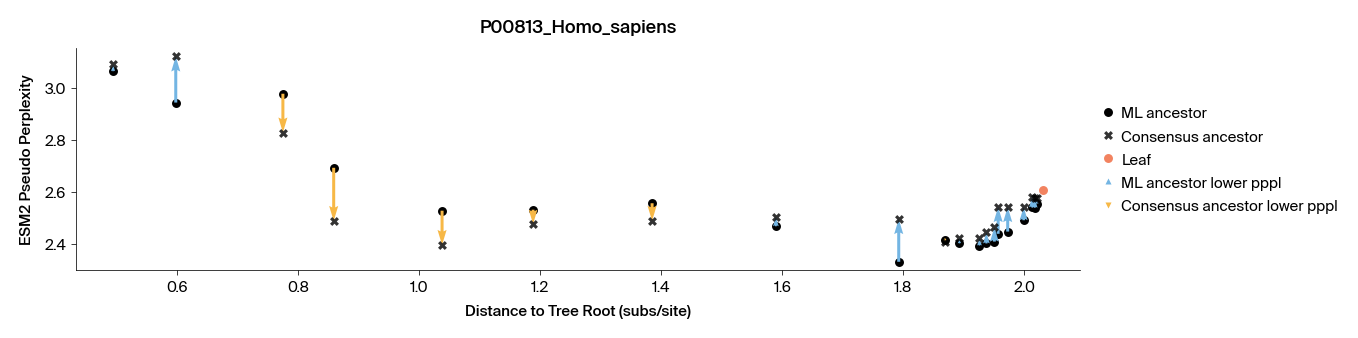

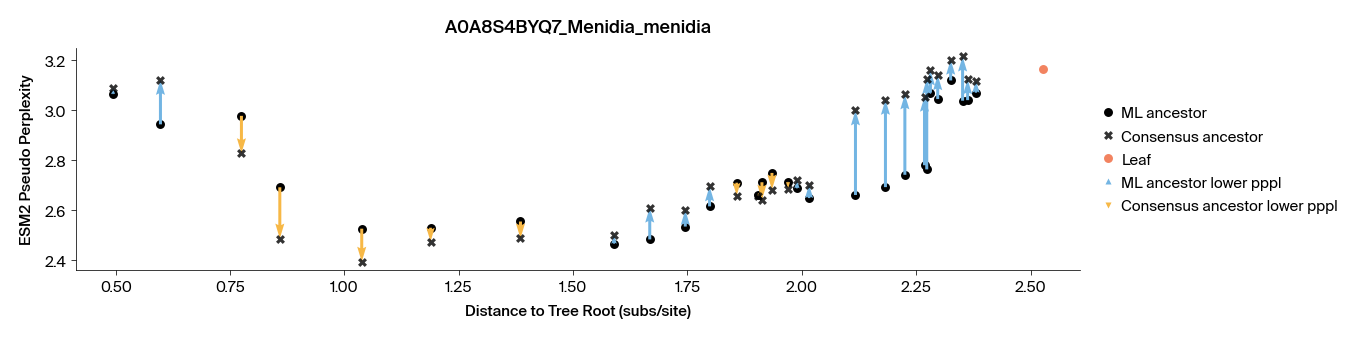

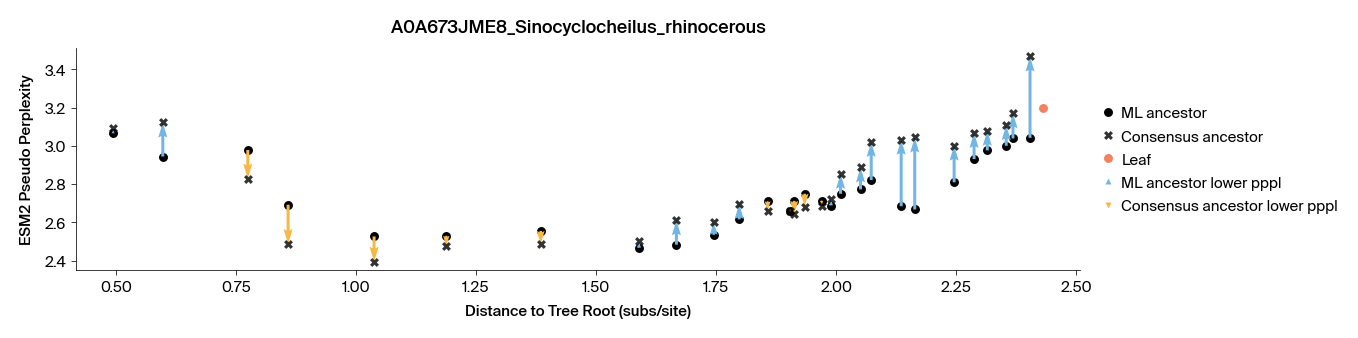

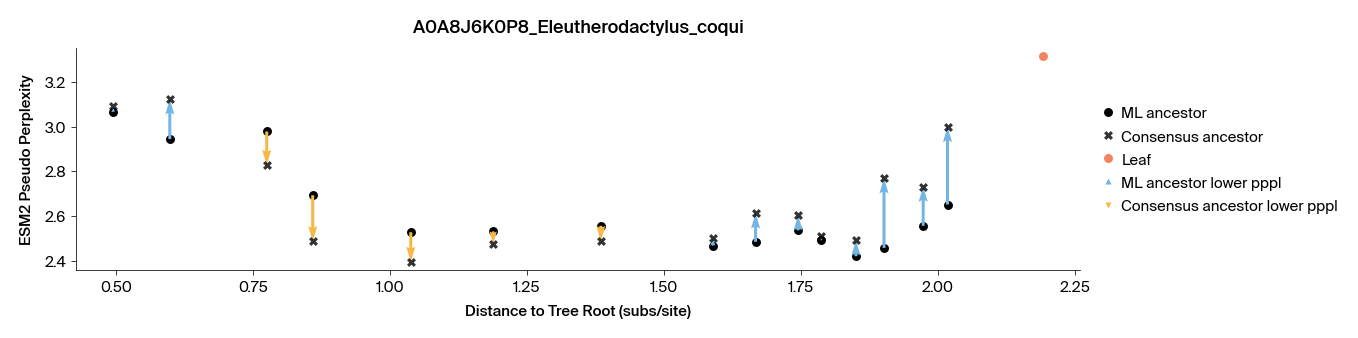

In [9]:
# | label: fig-6
# | column: body
# | fig-cap: ESM2 pseudo-perplexity scores for consensus and ML ancestors of ADA1, with arrows indicating which ancestor has the lower pseudo-perplexity score.
# | fig-subcap:
# |   - " "
# |   - " "
# |   - " "
# |   - " "

from data_processing import plot_evo_path_quiver

plot_evo_path_quiver(all_scores, tree, "P00813_Homo_sapiens")
plot_evo_path_quiver(all_scores, tree, "A0A8S4BYQ7_Menidia_menidia")
plot_evo_path_quiver(all_scores, tree, "A0A673JME8_Sinocyclocheilus_rhinocerous")
plot_evo_path_quiver(all_scores, tree, "A0A8J6K0P8_Eleutherodactylus_coqui")

Maximum likelihood ancestors frequently show lower pseudo-perplexity scores than their corresponding consensus ancestors. However, both types of ancestral sequences often scored lower than extant sequences, indicating that a consensus effect partially drives the observed preference for ancestral sequences.

However, the relationship between maximum likelihood and consensus ancestors varies with evolutionary distance. For recent ancestors, maximum likelihood sequences consistently outperform consensus ancestors, suggesting that ESM2 has learned to recognize evolutionarily informed reconstructions as more plausible than simple frequency-based sequences. This indicates that the model has internalized aspects of evolutionary relationships beyond mere amino acid frequency distributions. However, this relationship reverses for more ancient ancestors, where consensus sequences often achieve lower pseudo-perplexity scores than maximum likelihood reconstructions. These ancient reconstructions also exhibit lower posterior probabilities, so this reversal may reflect increased uncertainty and potential errors in the maximum likelihood reconstructions. Alternatively, this behavior could reflect over-fitting to native sequences, given that consensus sequences likely more closely match the frequency distributions of the training set. While it’s difficult to distinguish between these two factors for the oldest ancestors, for more recent ancestors it’s clear that ESM2 can infer that maximum likelihood ancestors are significantly more plausible than crude consensus ancestors.



## Comparing different ESM2 model sizes

We were curious to know how much of the evolutionary information ESM2 seems to be learning is consistent across different model sizes or whether this information is only captured in large models. To investigate this, we repeated the above analysis with different ESM2 model sizes: 8M, 35M, 150M, and 3B parameters (in addition to the previously shown 650M). 

In [10]:
small_model_scores = pd.read_csv("ESM2_scoring/ADA1_all_esm2_scores_8M.csv")
med_model_scores = pd.read_csv("ESM2_scoring/ADA1_all_esm2_scores_35M.csv")
large_model_scores = pd.read_csv("ESM2_scoring/ADA1_all_esm2_scores_150M.csv")
huge_model_scores = pd.read_csv("ESM2_scoring/ADA1_all_esm2_scores_3B.csv")

small_model_scores["ML prob"] = small_model_scores["sequence_id"].apply(
    lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan
)
small_model_scores["bl_to_root"] = small_model_scores["sequence_id"].apply(
    lambda x: calc_branch_length_to_root_node(tree, x[4:])
    if x.startswith("node")
    else calc_branch_length_to_root_leaf(tree, x)
)

med_model_scores["ML prob"] = med_model_scores["sequence_id"].apply(
    lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan
)
med_model_scores["bl_to_root"] = med_model_scores["sequence_id"].apply(
    lambda x: calc_branch_length_to_root_node(tree, x[4:])
    if x.startswith("node")
    else calc_branch_length_to_root_leaf(tree, x)
)

large_model_scores["ML prob"] = large_model_scores["sequence_id"].apply(
    lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan
)
large_model_scores["bl_to_root"] = large_model_scores["sequence_id"].apply(
    lambda x: calc_branch_length_to_root_node(tree, x[4:])
    if x.startswith("node")
    else calc_branch_length_to_root_leaf(tree, x)
)

huge_model_scores["ML prob"] = huge_model_scores["sequence_id"].apply(
    lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan
)
huge_model_scores["bl_to_root"] = huge_model_scores["sequence_id"].apply(
    lambda x: calc_branch_length_to_root_node(tree, x[4:])
    if x.startswith("node")
    else calc_branch_length_to_root_leaf(tree, x)
)

We can then plot the same relationship between ESM2 pseudo-perplexity and distance to tree root for these different model sizes to see if they exhibit similar behavior. 

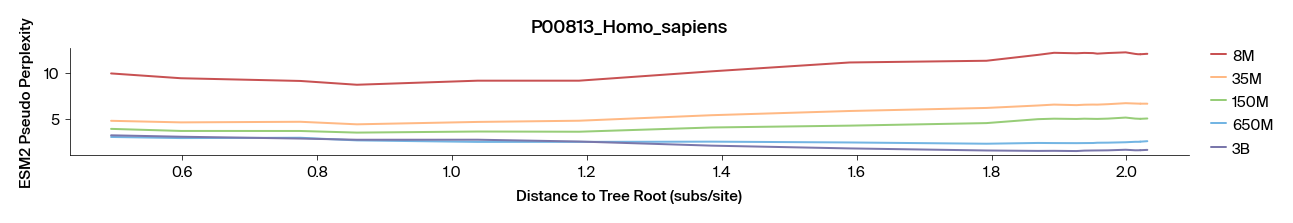

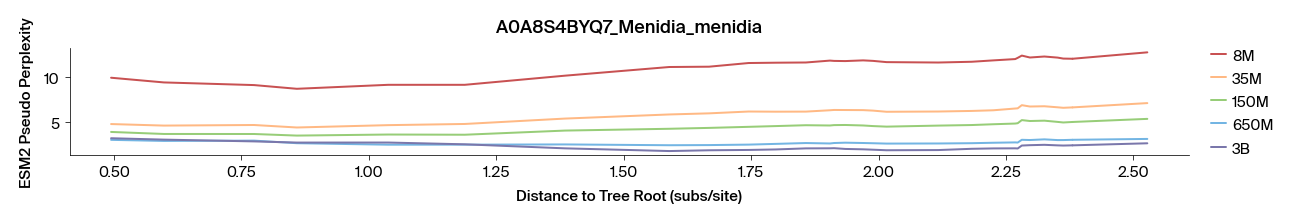

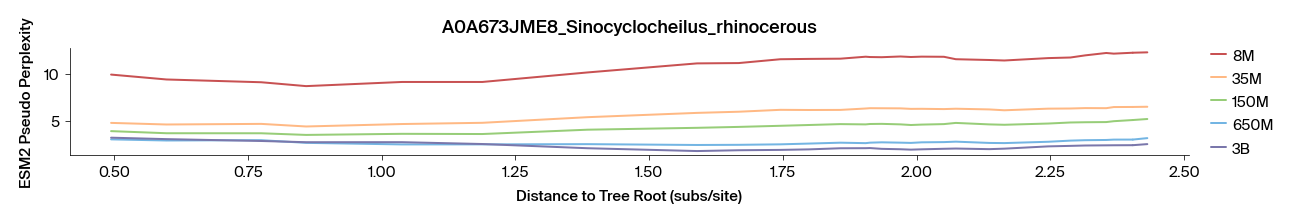

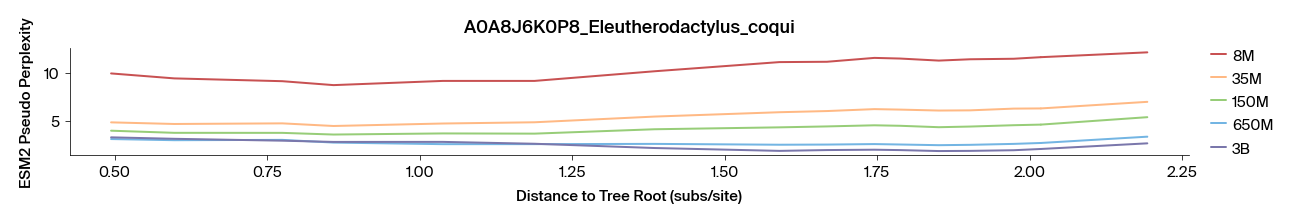

In [11]:
# | label: fig-7
# | column: body
# | fig-cap: ESM2 pseudo-perplexity vs distance to tree root for five different ESM2 model sizes for four species lineages.
# | fig-subcap:
# |   - " "
# |   - " "
# |   - " "
# |   - " "

from data_processing import plot_multiple_evo_lines

plot_multiple_evo_lines(
    [
        (small_model_scores, "P00813_Homo_sapiens", "8M"),
        (med_model_scores, "P00813_Homo_sapiens", "35M"),
        (large_model_scores, "P00813_Homo_sapiens", "150M"),
        (all_scores, "P00813_Homo_sapiens", "650M"),
        (huge_model_scores, "P00813_Homo_sapiens", "3B"),
    ],
    tree,
    normalize=False,
)
plot_multiple_evo_lines(
    [
        (small_model_scores, "A0A8S4BYQ7_Menidia_menidia", "8M"),
        (med_model_scores, "A0A8S4BYQ7_Menidia_menidia", "35M"),
        (large_model_scores, "A0A8S4BYQ7_Menidia_menidia", "150M"),
        (all_scores, "A0A8S4BYQ7_Menidia_menidia", "650M"),
        (huge_model_scores, "A0A8S4BYQ7_Menidia_menidia", "3B"),
    ],
    tree,
    normalize=False,
)
plot_multiple_evo_lines(
    [
        (small_model_scores, "A0A673JME8_Sinocyclocheilus_rhinocerous", "8M"),
        (med_model_scores, "A0A673JME8_Sinocyclocheilus_rhinocerous", "35M"),
        (large_model_scores, "A0A673JME8_Sinocyclocheilus_rhinocerous", "150M"),
        (all_scores, "A0A673JME8_Sinocyclocheilus_rhinocerous", "650M"),
        (huge_model_scores, "A0A673JME8_Sinocyclocheilus_rhinocerous", "3B"),
    ],
    tree,
    normalize=False,
)
plot_multiple_evo_lines(
    [
        (small_model_scores, "A0A8J6K0P8_Eleutherodactylus_coqui", "8M"),
        (med_model_scores, "A0A8J6K0P8_Eleutherodactylus_coqui", "35M"),
        (large_model_scores, "A0A8J6K0P8_Eleutherodactylus_coqui", "150M"),
        (all_scores, "A0A8J6K0P8_Eleutherodactylus_coqui", "650M"),
        (huge_model_scores, "A0A8J6K0P8_Eleutherodactylus_coqui", "3B"),
    ],
    tree,
    normalize=False,
)

Larger models consistently produce overall lower pseudo-perplexity scores, reflecting their improved ability to learn protein sequence patterns. However, the relationship between pseudo-perplexity and evolutionary age varies across model sizes.  To facilitate easier comparison across models, we normalized all pseudo-perplexity values to each model's extant sequence pseudo-perplexity score.


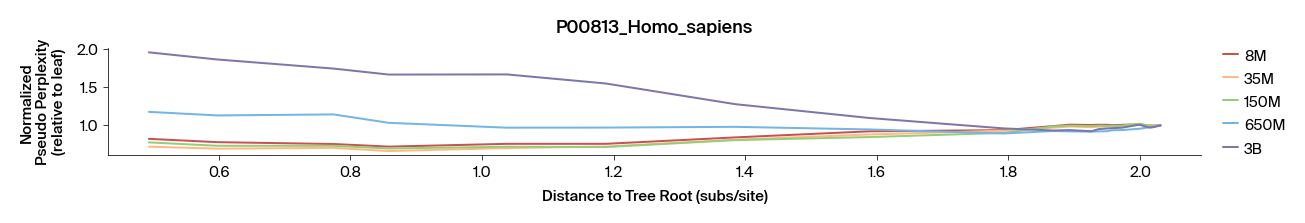

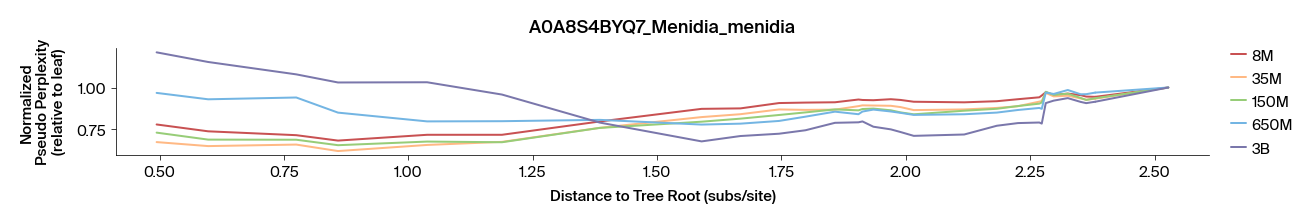

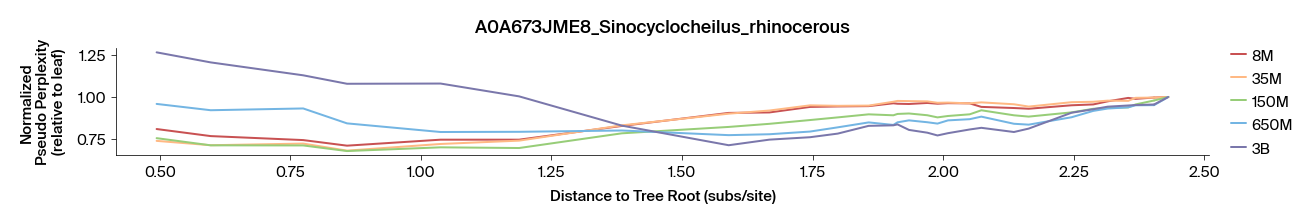

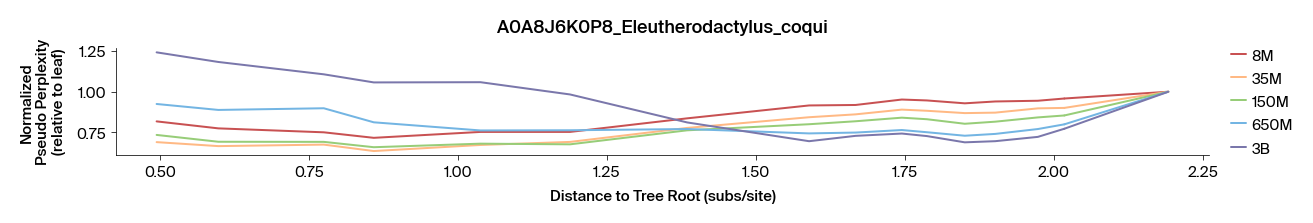

In [12]:
# | label: fig-8
# | column: body
# | fig-cap: Normalized ESM2 pseudo-perplexity vs distance to tree root for different ESM2 model sizes. For each species lineage, the pseudo-perplexity scores for each model are normalized to the score for the extant sequence for that model size.
# | fig-subcap:
# |   - " "
# |   - " "
# |   - " "
# |   - " "

plot_multiple_evo_lines(
    [
        (small_model_scores, "P00813_Homo_sapiens", "8M"),
        (med_model_scores, "P00813_Homo_sapiens", "35M"),
        (large_model_scores, "P00813_Homo_sapiens", "150M"),
        (all_scores, "P00813_Homo_sapiens", "650M"),
        (huge_model_scores, "P00813_Homo_sapiens", "3B"),
    ],
    tree,
)
plot_multiple_evo_lines(
    [
        (small_model_scores, "A0A8S4BYQ7_Menidia_menidia", "8M"),
        (med_model_scores, "A0A8S4BYQ7_Menidia_menidia", "35M"),
        (large_model_scores, "A0A8S4BYQ7_Menidia_menidia", "150M"),
        (all_scores, "A0A8S4BYQ7_Menidia_menidia", "650M"),
        (huge_model_scores, "A0A8S4BYQ7_Menidia_menidia", "3B"),
    ],
    tree,
)
plot_multiple_evo_lines(
    [
        (small_model_scores, "A0A673JME8_Sinocyclocheilus_rhinocerous", "8M"),
        (med_model_scores, "A0A673JME8_Sinocyclocheilus_rhinocerous", "35M"),
        (large_model_scores, "A0A673JME8_Sinocyclocheilus_rhinocerous", "150M"),
        (all_scores, "A0A673JME8_Sinocyclocheilus_rhinocerous", "650M"),
        (huge_model_scores, "A0A673JME8_Sinocyclocheilus_rhinocerous", "3B"),
    ],
    tree,
)
plot_multiple_evo_lines(
    [
        (small_model_scores, "A0A8J6K0P8_Eleutherodactylus_coqui", "8M"),
        (med_model_scores, "A0A8J6K0P8_Eleutherodactylus_coqui", "35M"),
        (large_model_scores, "A0A8J6K0P8_Eleutherodactylus_coqui", "150M"),
        (all_scores, "A0A8J6K0P8_Eleutherodactylus_coqui", "650M"),
        (huge_model_scores, "A0A8J6K0P8_Eleutherodactylus_coqui", "3B"),
    ],
    tree,
)

This normalization reveals distinct differences in how models of varying sizes score ancestors of different ages. The larger models (650M and 3B parameters) show dramatic increases in pseudo-perplexity for the oldest ancestors compared to recent ancestors or extant sequences, while the smallest models show only gradual increases for these ancient sequences. Conversely, the largest models demonstrate the most significant decreases in pseudo-perplexity for the most recent ancestors relative to extant sequences.

These patterns suggest the models learn evolutionary principles to markedly different extents. The largest models disfavor low-confidence reconstructions while favoring high-confidence reconstructions. This could reflect genuine evolutionary learning or overfitting to native-like sequences. Meanwhile, the smallest models show minimal pseudo-perplexity differences from native to deepest ancestors, though their absolute scores remain relatively high (>10) compared to the much lower scores (<3) of larger models.

Most importantly, these results demonstrate that ESM2 model size is critically essential for evolutionary analysis. Depending on which model size you use for this analysis, you could reach vastly different conclusions: that all ancestors are more plausible than native sequences, that some ancestors are more plausible, that ancestors and native sequences are similarly plausible, or that ancestral age strongly affects plausibility.


## Second example gene: yeast isomaltase

We examined yeast isomaltase to explore whether these findings generalized to other proteins. Isomaltase produced high-quality alignments and phylogenetic trees, was relatively small for pseudo-perplexity calculations (589 amino acids), and showed a phylogenetic structure similar to ADA1. Ancestral reconstructions displayed high confidence toward terminal leaves and lower (but still reasonable) confidence at basal nodes. While not all gene phylogenies follow this pattern, we wanted to understand how ESM2 behaves with this fairly typical phylogenetic structure. Future work could expand this analysis to genes with more diverse phylogenetic patterns to examine how pseudo-perplexity varies across different tree topologies.

We selected three extant leaves to interrogate in the same manner as above, their location on the isomaltase phylogenetic tree is shown below.


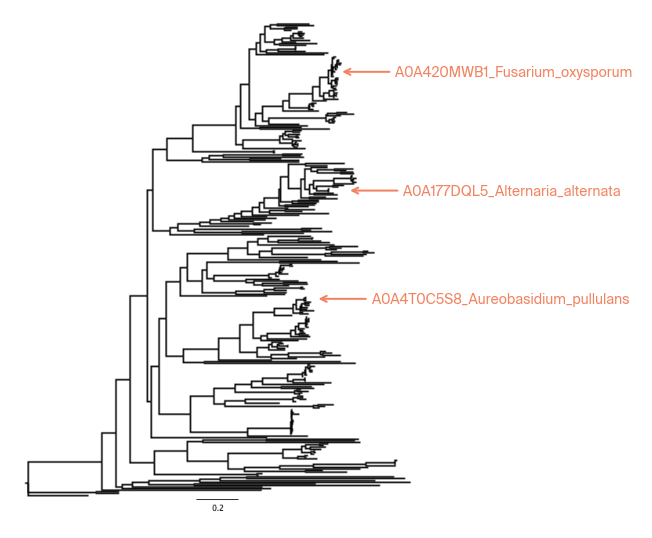

In [13]:
# | label: fig-9
# | fig-cap: Phylogenetic tree of isomaltase with extant leaf positions indicated by arrows.

img_path = "images/isomaltase_tree.png"
plot_image_with_arrows(
    img_path,
    x_starts=[0.94, 0.96, 0.88],
    x_ends=[0.81, 0.83, 0.75],
    arrow_ys=[0.105, 0.343, 0.56],
    labels=[
        "A0A420MWB1_Fusarium_oxysporum",
        "A0A177DQL5_Alternaria_alternata",
        "A0A4T0C5S8_Aureobasidium_pullulans",
    ],
    text_offsets=[0.01, 0.01, 0.01],
)

It's worth noting that the scale of substitutions per site is much smaller for isomaltase than ADA1, indicating that these sequences are less divergent (maximum branch length ~1.5 vs. ~2.5 for ADA1). Correspondingly, the overall ASR mean posterior probabilities are also higher.

We can then plot the ESM2 pseudo-perplexity (650M parameter model) compared to the distance to tree root as we did for ADA1 for all three leaves.


In [14]:
# get ESM2 scores for isomaltase
iso_scores = pd.read_csv("ESM2_scoring/isomaltase_all_esm2_scores_650M.csv")

# retrieve the dictionary of probabilities from PAML output
ml_probs_json = "ASR/Isomaltase_ASR/posterior_probabilities_no_gaps.json"
ml_probs_json = Path(ml_probs_json)
with open(ml_probs_json) as f:
    iso_probs_dict = json.load(f)

iso_scores["ML prob"] = iso_scores["sequence_id"].apply(
    lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan
)

tree_file = "ASR/Isomaltase_ASR/ancestor_tree.txt"
iso_tree = Phylo.read(tree_file, "newick")

iso_scores["bl_to_root"] = iso_scores["sequence_id"].apply(
    lambda x: calc_branch_length_to_root_node(iso_tree, x[4:])
    if x.startswith("node")
    else calc_branch_length_to_root_leaf(iso_tree, x)
)

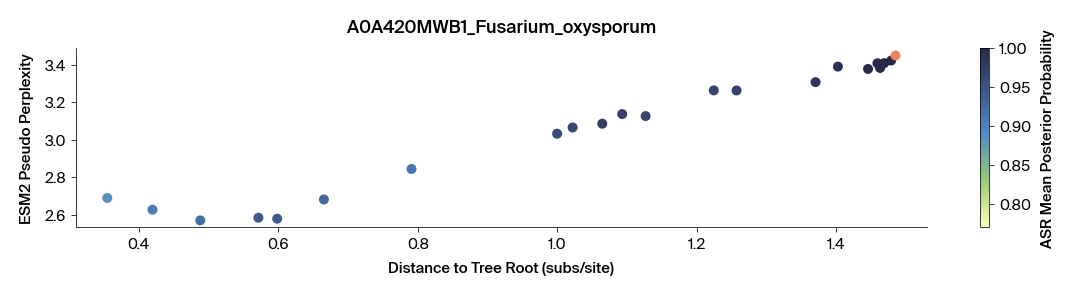

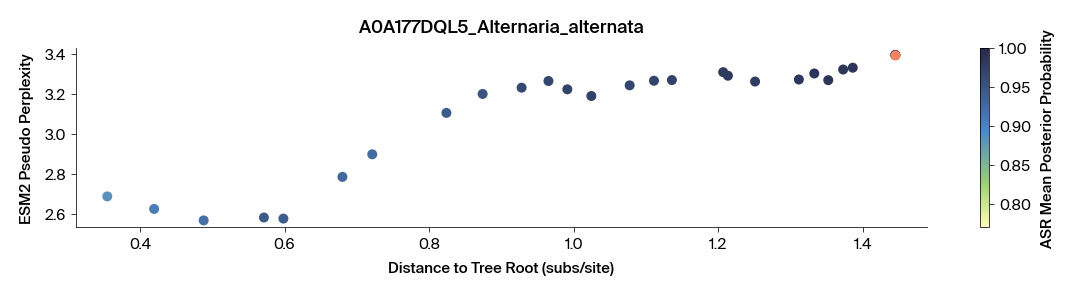

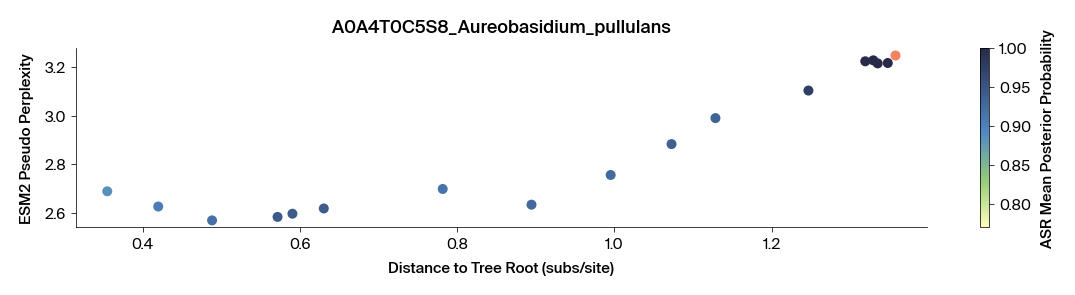

In [15]:
# | label: fig-10
# | column: body
# | fig-cap: ESM2 pseudo-perplexity scores for isomaltase sequences, colored by ML posterior probability bin. The x-axis shows the branch length to the root node of the tree, with the extant sequence on the far right (orange). The y-axis shows ESM2 pseudo-perplexity score.
# | fig-subcap:
# |   - " "
# |   - " "
# |   - " "
# |   - " "

plot_evo_path(iso_scores, iso_tree, "A0A420MWB1_Fusarium_oxysporum", labels=False)
plot_evo_path(iso_scores, iso_tree, "A0A177DQL5_Alternaria_alternata", labels=False)
plot_evo_path(iso_scores, iso_tree, "A0A4T0C5S8_Aureobasidium_pullulans", labels=False)

Isomaltase reveals similar but attenuated patterns compared to ADA1: pseudo-perplexity decreases among recent ancestors relative to extant sequences, though less pronounced than ADA1. This is followed by leveling off and slight increases for the oldest ancestors, again much less dramatic than the ADA1 pattern. These results confirm that ESM2's preference for ancestral sequences over native sequences extends to this second gene family. However, we don't observe the sharp increase in pseudo-perplexity seen with ADA1's most ancient ancestors, likely because isomaltase lacks reconstructions with comparably low posterior probabilities or similar branch length divergence.

We also generated consensus ancestral sequences for isomaltase and compared their ESM2 pseudo-perplexity scores to maximum likelihood ancestral sequences.


In [16]:
# generate isomaltase consensus ancestors

leaves_of_interest = [
    "A0A420MWB1_Fusarium_oxysporum",
    "A0A177DQL5_Alternaria_alternata",
    "A0A4T0C5S8_Aureobasidium_pullulans",
]
ancestors_of_interest = []

for entry in leaves_of_interest:
    ancestors_of_interest.extend(get_node_labels_leaf_to_root(iso_tree, entry))

ancestors_of_interest = list(set(ancestors_of_interest))

alignment_file = "ASR/Isomaltase_ASR/isomaltase_dereplicated_final_recoded_mafft.fa"
name_conv_dict = "ASR/Isomaltase_ASR/recoding_dict.txt"
gap_dict_json = "ASR/Isomaltase_ASR/gap_positions.json"

consensus_seq_file = "consensus_isomaltase_ancestors.fa"

records = []
for entry in ancestors_of_interest:
    consensus_seq = generate_node_consensus(
        iso_tree, entry, alignment_file, name_conv_dict, gap_dict_json
    )
    name = entry + "_consensus"
    record = SeqRecord(Seq(consensus_seq), id=name, description="")
    records.append(record)

# Write all consensus sequences to a FASTA file
# consensus_seq_file = Path(consensus_seq_file)
# with open(consensus_seq_file, "w") as file:
#     SeqIO.write(records, file, "fasta")

In [17]:
# retrieve esm2 scores for consensus seqs
consensus_file = (
    "ESM2_scoring/consensus_ancestors/consensus_isomaltase_ancestors_esm2_scores_650M.csv"
)
consensus_scores = pd.read_csv(consensus_file)
consensus_scores["orig_id"] = consensus_scores["sequence_id"].apply(
    lambda x: x.replace("_consensus", "")
)
consensus_scores = consensus_scores[["orig_id", "sequence", "pseudo_perplexity"]]
consensus_scores = consensus_scores.rename(
    columns={
        "sequence": "consensus_seq",
        "pseudo_perplexity": "consensus_pppl",
        "orig_id": "sequence_id",
    }
)


# add new consensus seqs and scores to scores df
iso_scores = iso_scores.merge(consensus_scores, how="left", on="sequence_id")

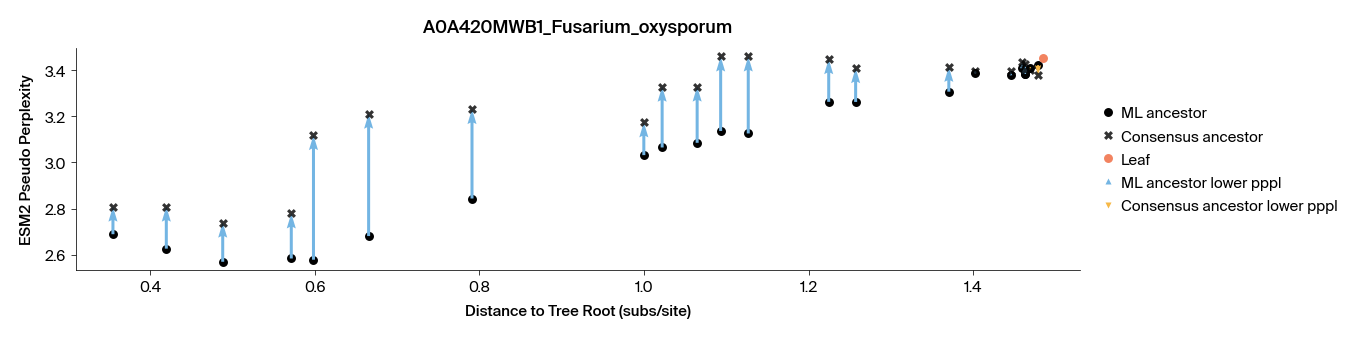

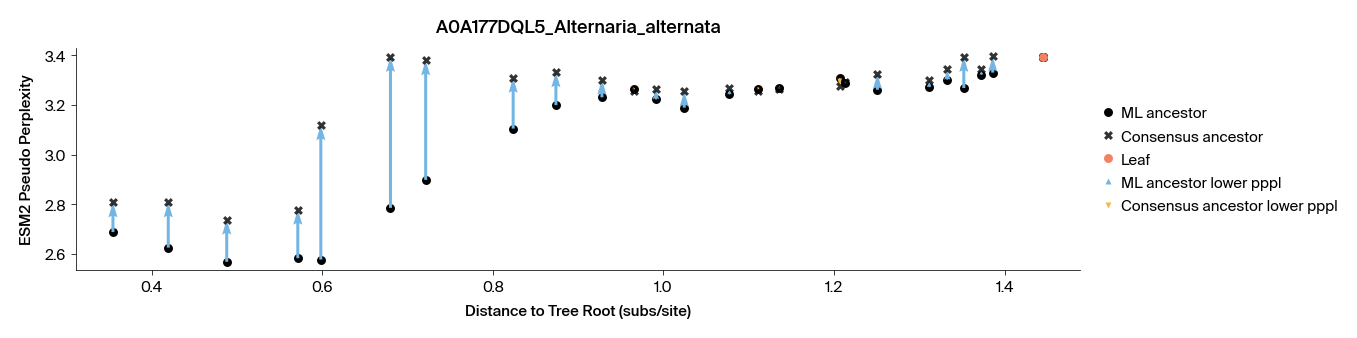

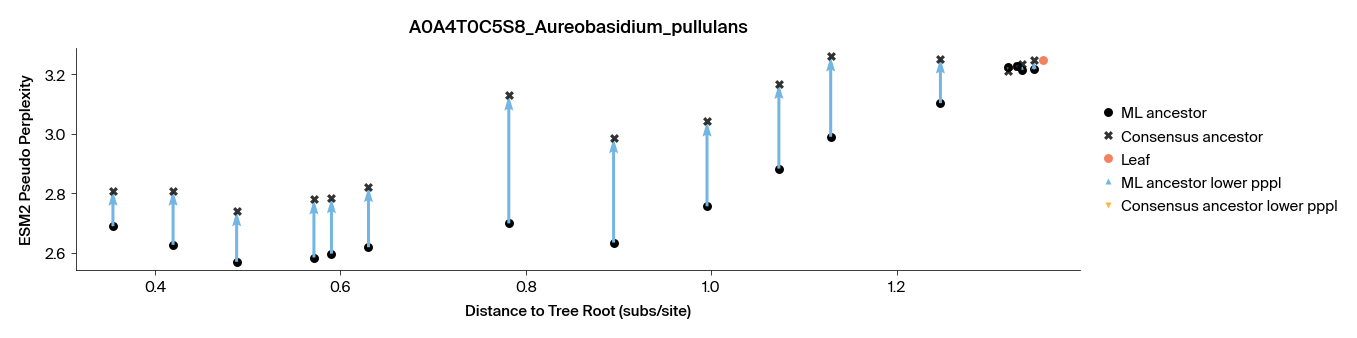

In [18]:
# | label: fig-11
# | column: body
# | fig-cap: ESM2 pseudo-perplexity scores for consensus and ML ancestors of ADA1, with arrows indicating which ancestor has the lower pseudo-perplexity score.
# | fig-subcap:
# |   - " "
# |   - " "
# |   - " "

plot_evo_path_quiver(iso_scores, iso_tree, "A0A420MWB1_Fusarium_oxysporum")
plot_evo_path_quiver(iso_scores, iso_tree, "A0A177DQL5_Alternaria_alternata")
plot_evo_path_quiver(iso_scores, iso_tree, "A0A4T0C5S8_Aureobasidium_pullulans")

This comparison shows distinct behavior from ADA1. In virtually all cases, pseudo-perplexity scores for maximum likelihood ancestors were lower than those for consensus ancestors. Overall, the model greatly prefers maximum likelihood ancestors for isomaltase, suggesting that the phylogenetic signal has been largely learned by the model rather than simple amino acid frequency distributions.

We also tested these sequences using different-sized ESM2 models to see if we observe differences between model sizes, as with ADA1. Below are the normalized scores.


In [19]:
# load esm2 scores for isomaltase

iso_small_model_scores = pd.read_csv("ESM2_scoring/isomaltase_all_esm2_scores_8M.csv")
iso_med_model_scores = pd.read_csv("ESM2_scoring/isomaltase_all_esm2_scores_35M.csv")
iso_large_model_scores = pd.read_csv("ESM2_scoring/isomaltase_all_esm2_scores_150M.csv")
iso_huge_model_scores = pd.read_csv("ESM2_scoring/isomaltase_all_esm2_scores_3B.csv")

iso_small_model_scores["ML prob"] = iso_small_model_scores["sequence_id"].apply(
    lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan
)
iso_small_model_scores["bl_to_root"] = iso_small_model_scores["sequence_id"].apply(
    lambda x: calc_branch_length_to_root_node(iso_tree, x[4:])
    if x.startswith("node")
    else calc_branch_length_to_root_leaf(iso_tree, x)
)

iso_med_model_scores["ML prob"] = iso_med_model_scores["sequence_id"].apply(
    lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan
)
iso_med_model_scores["bl_to_root"] = iso_med_model_scores["sequence_id"].apply(
    lambda x: calc_branch_length_to_root_node(iso_tree, x[4:])
    if x.startswith("node")
    else calc_branch_length_to_root_leaf(iso_tree, x)
)

iso_large_model_scores["ML prob"] = iso_large_model_scores["sequence_id"].apply(
    lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan
)
iso_large_model_scores["bl_to_root"] = iso_large_model_scores["sequence_id"].apply(
    lambda x: calc_branch_length_to_root_node(iso_tree, x[4:])
    if x.startswith("node")
    else calc_branch_length_to_root_leaf(iso_tree, x)
)

iso_huge_model_scores["ML prob"] = iso_huge_model_scores["sequence_id"].apply(
    lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan
)
iso_huge_model_scores["bl_to_root"] = iso_huge_model_scores["sequence_id"].apply(
    lambda x: calc_branch_length_to_root_node(iso_tree, x[4:])
    if x.startswith("node")
    else calc_branch_length_to_root_leaf(iso_tree, x)
)

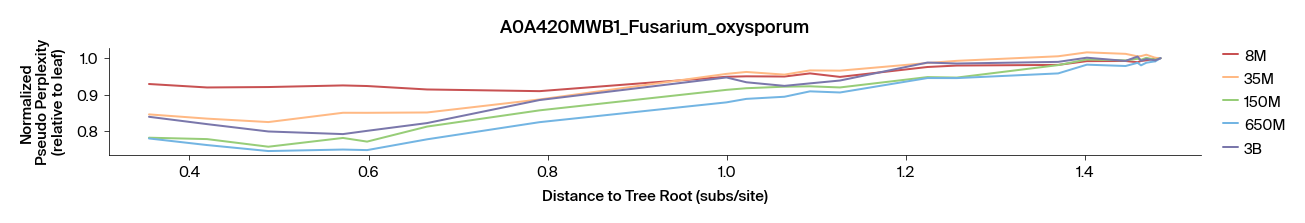

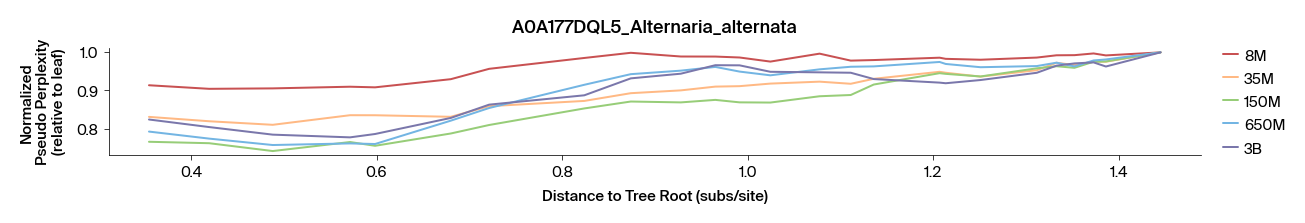

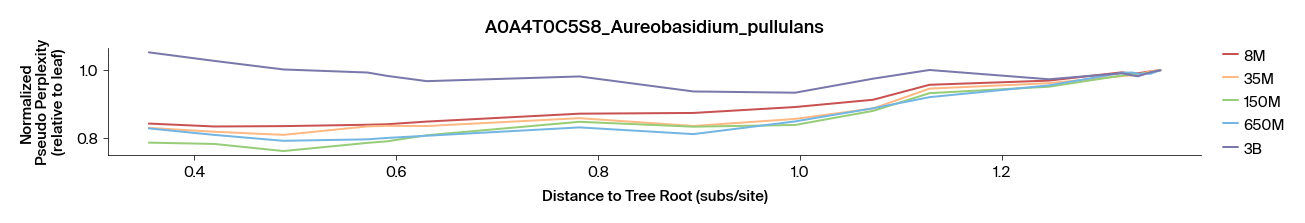

In [20]:
# | label: fig-12
# | column: body
# | fig-cap: Normalized ESM2 pseudo-perplexity vs distance to tree root for different ESM2 model sizes. For each species lineage, the pseudo-perplexity scores for each model are normalized to the score for the extant sequence for that model size.
# | fig-subcap:
# |   - " "
# |   - " "
# |   - " "


plot_multiple_evo_lines(
    [
        (iso_small_model_scores, "A0A420MWB1_Fusarium_oxysporum", "8M"),
        (iso_med_model_scores, "A0A420MWB1_Fusarium_oxysporum", "35M"),
        (iso_large_model_scores, "A0A420MWB1_Fusarium_oxysporum", "150M"),
        (iso_scores, "A0A420MWB1_Fusarium_oxysporum", "650M"),
        (iso_huge_model_scores, "A0A420MWB1_Fusarium_oxysporum", "3B"),
    ],
    iso_tree,
    normalize=True,
)
plot_multiple_evo_lines(
    [
        (iso_small_model_scores, "A0A177DQL5_Alternaria_alternata", "8M"),
        (iso_med_model_scores, "A0A177DQL5_Alternaria_alternata", "35M"),
        (iso_large_model_scores, "A0A177DQL5_Alternaria_alternata", "150M"),
        (iso_scores, "A0A177DQL5_Alternaria_alternata", "650M"),
        (iso_huge_model_scores, "A0A177DQL5_Alternaria_alternata", "3B"),
    ],
    iso_tree,
    normalize=True,
)
plot_multiple_evo_lines(
    [
        (iso_small_model_scores, "A0A4T0C5S8_Aureobasidium_pullulans", "8M"),
        (iso_med_model_scores, "A0A4T0C5S8_Aureobasidium_pullulans", "35M"),
        (iso_large_model_scores, "A0A4T0C5S8_Aureobasidium_pullulans", "150M"),
        (iso_scores, "A0A4T0C5S8_Aureobasidium_pullulans", "650M"),
        (iso_huge_model_scores, "A0A4T0C5S8_Aureobasidium_pullulans", "3B"),
    ],
    iso_tree,
    normalize=True,
)

Here, we observe a similar phenomenon where the smallest models showed largely consistent pseudo-perplexity scores. In contrast, the largest models showed more pronounced increases in pseudo-perplexity than the oldest ancestors. This pattern was consistent with ADA1 observations but less dramatic. Nonetheless, this observation is consistent with the idea that selection of ESM2 model size is essential in interpreting the plausibility of ancestral sequences relative to native.

## Relationship between ASR confidence and ESM2 pseudo-perplexity

The isomaltase results prompted us to investigate whether a general relationship exists between maximum likelihood ancestral reconstruction posterior probabilities and ESM2 pseudo-perplexity. We pooled results from both ADA1 and isomaltase phylogenies and calculated pseudo-perplexity scores for all native and ancestral sequences using the 650M parameter model.

In [21]:
# pull data for all remaining ADA1 sequences
remaining_df = pd.read_csv("ESM2_scoring/ADA1_remaining_esm2_scores_650M.csv")
remaining_df = remaining_df[["sequence_id", "sequence", "pseudo_perplexity"]]

# combine with original scores
all_scores = pd.read_csv("ESM2_scoring/ADA1_all_esm2_scores_650M.csv")
all_scores = all_scores[["sequence_id", "sequence", "pseudo_perplexity"]]
full_data = pd.concat([remaining_df, all_scores])

# Add in ML posterior probabilities from ASR run
ml_probs_json = "ASR/ADA1_ASR/posterior_probabilities_no_gaps.json"
ml_probs_json = Path(ml_probs_json)
with open(ml_probs_json) as f:
    probs_dict = json.load(f)
full_data["ML prob"] = full_data["sequence_id"].apply(
    lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan
)
full_data["ML prob"] = full_data["ML prob"].fillna(1.1)

# pull data for all iso native and ancestor
remaining_df = pd.read_csv("ESM2_scoring/isomaltase_remaining_esm2_scores_650M.csv")
remaining_df = remaining_df[["sequence_id", "sequence", "pseudo_perplexity"]]

# combine with original scores
iso_scores = pd.read_csv("ESM2_scoring/isomaltase_all_esm2_scores_650M.csv")
iso_scores = iso_scores[["sequence_id", "sequence", "pseudo_perplexity"]]
full_data_iso = pd.concat([remaining_df, iso_scores])

# Retrieve ML posterior probabilities from ASR run
ml_probs_json = "ASR/Isomaltase_ASR/posterior_probabilities_no_gaps.json"
ml_probs_json = Path(ml_probs_json)
with open(ml_probs_json) as f:
    probs_dict_iso = json.load(f)
full_data_iso["ML prob"] = full_data_iso["sequence_id"].apply(
    lambda x: np.mean([max(x) for x in probs_dict_iso[x]]) if x in probs_dict_iso else np.nan
)
full_data_iso["ML prob"] = full_data_iso["ML prob"].fillna(1.1)

# merge all data together
full_data_both = pd.concat([full_data, full_data_iso])
full_data_both = full_data_both.drop_duplicates()

# print sizes of each
print(f"Total ADA1 sequences: {len(full_data)}")
print(f"Total Isomaltase sequences: {len(full_data_iso)}")

Total ADA1 sequences: 461
Total Isomaltase sequences: 571


We can then view the relationship between ML posterior probability and ESM2 pseudo-perplexity for all these sequences.

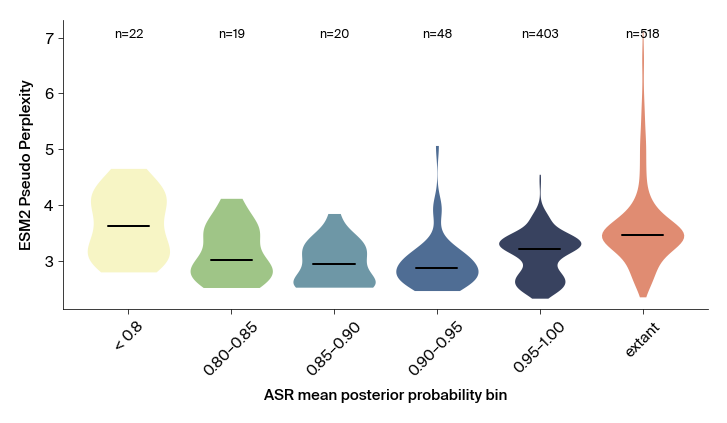

In [22]:
# | code-fold: true
# | label: fig-13
# | fig-cap: Violin plot of ESM2 pseudo-perplexity scores for both ADA1 and isomaltase sequences, binned by ML posterior probability. Horizontal bar indicates median score in each bin and number of samples in each bin indicated above.

from data_processing import violin_plot

bins = [0.7, 0.8, 0.85, 0.9, 0.95, 1.0, 1.1]
bin_labels = ["< 0.8", "0.80–0.85", "0.85–0.90", "0.90–0.95", "0.95–1.00", "extant"]

violin_plot(full_data_both, bins, bin_labels)

Here we do observe a broad pattern. We see the highest median pseudo-perplexity for extant sequences. Values decrease in the 0.95-1.0 and 0.90-0.95 posterior probability bins, level off in the 0.85-0.9 bins, and begin increasing again as probabilities drop below 0.85. 

To test the significance of these differences, we performed a Kruskal–Wallis and Dunn-Bonferroni post-hoc test.

In [24]:
from data_processing import kruskal_wallis_with_significant_posthoc

# Perform Kruskal-Wallis test and Dunn Benforroni and print significant comparisons
kruskal_wallis_with_significant_posthoc(full_data_both, bins, bin_labels)

Kruskal-Wallis test result: H = 191.825, p = 1.591e-39

Significant Dunn post hoc comparisons (adjusted p < 0.05):
Group 1      Group 2      Adj. p-value
--------------------------------------
< 0.8        0.85–0.90    4.420e-04   
< 0.8        0.90–0.95    5.322e-06   
< 0.8        0.95–1.00    4.800e-04   
0.85–0.90    extant       4.610e-06   
0.90–0.95    extant       5.500e-14   
0.95–1.00    extant       3.694e-31   


These analyses indicate a significant effect of ML posterior probability bin on pseudo-perplexity (p<< 0.001). Post hoc tests revealed that both extant sequences and the lowest-confidence ancestral reconstructions (<0.8) exhibit significantly higher pseudo-perplexity than the high-confidence reconstructed bins. Differences among the intermediate confidence bins themselves weren't statistically significant.

While broader generalization will require analyzing more genes, these results support the idea that ancestral sequences tend to show lower pseudo-perplexity than extant sequences, up to a point. Once mean posterior probabilities drop below ~0.85, pseudo-perplexity increases, suggesting the model becomes less confident in these reconstructed sequences (for the 650M parameter ESM2 model).

## Discussion and Conclusions

Our analysis suggests that ESM2 models, particularly at larger scales, capture some aspects of evolutionary signal in a context-dependent and inconsistent manner. While it's difficult to distinguish true phylogenetic understanding from overfitting to training sequences, we observe several intriguing patterns:

**Lower pseudo-perplexity for ancestral sequences**. Across both gene families and species, ESM2 often assigns lower pseudo-perplexity scores to reconstructed ancestral sequences than to extant descendants. This pattern is especially pronounced for high-confidence reconstructions, even though these ancestral sequences weren't in the training data. This behavior has been previously observed for other protein families (@kantroo_pseudo-perplexity_2024)

**Discrimination between ML and consensus ancestors**. In cases where reconstructions are well-supported, ESM2 prefers maximum likelihood ancestors over simple consensus sequences, suggesting sensitivity to subtle features of evolutionary plausibility beyond mere amino acid frequency. However, this preference weakens for ancient or low-confidence ancestors, likely reflecting poor reconstruction quality or increasing divergence from the training set distribution.

**Model size affects evolutionary patterns**. While larger ESM2 models (650M and 3B parameters) show more nuanced relationships between reconstruction confidence and evolutionary age, smaller models show flatter distributions, indicating reduced sensitivity. This suggests that some of this ability to interpret evolutionary relationships may emerge only in larger models.

While these findings are limited to two gene families and a specific ASR approach, they support that ESM2's treatment of ancestral sequences isn't random and may reflect partial capture of phylogenetic information. Still, the patchiness of the observed patterns cautions against strong claims. Further investigation is needed to determine whether large protein language models like ESM2 genuinely encode evolutionary relationships, and orthogonal approaches may be needed to more deeply interrogate this idea. (@ektefaie_sequence_2025)


## References